In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import os
from os import listdir
import pims

In [2]:
def getfiles(extension = 'SPE' ,folder = os.getcwd(), search=None):
    """
    Returns a list of filepaths of specified type (SPE by default) within given or current(default) folder.
    """
    path = folder + '/{}'
    
    files = [path.format(f) for f in listdir(folder) if f.endswith('.' + extension)]
    
    if search!=None:
        files = [f for f in files if search in f]
    return files

In [3]:
# Path where files are
data_path = 'C:/Users/mrdxy/Documents/Analysis_Master_Thesis/2021_09_03_CHO_Bleachingcurves'

In [4]:
# Files get extracted
all_files = getfiles(extension = 'SPE' ,folder = data_path)
all_files = sorted(all_files)

In [5]:
# Use later as reference for which index means what
files_488_1000 = all_files[0:6]
files_488_2000 = all_files[6:12]
files_488_3000 = all_files[12:18]
files_488_4000 = all_files[18:24]
files_488_5000 = all_files[24:30]
files_488_0500 = all_files[30:37]
files_488_6000 = all_files[37:43]
files_647_1000 = all_files[43:49]
files_647_2000 = all_files[49:55]
files_647_3000 = all_files[55:61]
files_647_4000 = all_files[61:67]; files_647_4000 = files_647_4000[:-1]
files_647_5000 = all_files[67:73]
files_647_0500 = all_files[73:80]
files_647_6000 = all_files[80:86]

In [6]:
def fit_func(x, A, alpha, beta, offset):
    return A*(1-offset)*np.exp(-alpha*x) + (1-A)*(1-offset)*np.exp(-beta*x) + offset

In [7]:
files_groups = [files_488_0500, files_488_1000, files_488_2000, files_488_3000,
                files_488_4000, files_488_5000, files_488_6000, files_647_0500,
                files_647_1000, files_647_2000, files_647_3000, files_647_4000,
                files_647_5000, files_647_6000]
files_names = ['AF488_0500W', 'AF488_1000W', 'AF488_2000W', 'AF488_3000W',
               'AF488_4000W', 'AF488_5000W', 'AF488_6000W', 'AF647_0500W',
               'AF647_1000W', 'AF647_2000W', 'AF647_3000W', 'AF647_4000W',
               'AF647_5000W', 'AF647_6000W']

In [8]:
all_A = []; all_A_error = []
all_alpha = []; all_alpha_error = []
all_beta = []; all_beta_error = []
all_offset = []; all_offset_error = []

for files, name in zip(files_groups, files_names):
    A_results = []
    alpha_results = []
    beta_results = []
    offset_results = []
    A_fit_sigmas = []
    alpha_fit_sigmas = []
    beta_fit_sigmas = []
    offset_fit_sigmas = []
    for f in files:
        with pims.open(f) as seq:
            temp = []
            for img in seq[2:]:
                temp.append(np.sum(img))
                
        result_array = np.array(temp)
        result_array = result_array/result_array[0]
        popt, pcov = curve_fit(fit_func, np.arange(len(result_array)), result_array, p0=(0.6, 0.01, 0.001, 0), bounds=([0.5, 0.0, 0.0, 0], [1.0, np.inf, np.inf, np.inf]))
        A_results.append(popt[0])
        A_fit_sigmas.append(pcov[0,0])
        alpha_results.append(popt[1])
        alpha_fit_sigmas.append(pcov[1,1])
        beta_results.append(popt[2])
        beta_fit_sigmas.append(pcov[2,2])
        offset_results.append(popt[3])
        offset_fit_sigmas.append(pcov[3,3])
        
    A = np.mean(np.array(A_results)); all_A.append(A)
    A_error = np.std(np.array(A_results)); all_A_error.append(A_error)
    alpha = 1000*np.mean(np.array(alpha_results)); all_alpha.append(alpha)
    alpha_error = 1000*np.std(np.array(alpha_results)); all_alpha_error.append(alpha_error)
    beta = 1000*np.mean(np.array(beta_results)); all_beta.append(beta)
    beta_error = 1000*np.std(np.array(beta_results)); all_beta_error.append(beta_error)
    offset = np.mean(np.array(offset_results)); all_offset.append(offset)
    offset_error = np.std(np.array(offset_results)); all_offset_error.append(offset_error)

In [9]:
results_dict = {'Identifier': files_names,
              'A': all_A,
              'A_std': all_A_error,
              'alpha': all_alpha,
              'alpha_std': all_alpha_error,
              'beta': all_beta,
              'beta_std': all_beta_error,
              'offset': all_offset,
              'offset_std': all_offset_error}
df_results = pd.DataFrame(results_dict)

In [10]:
excel_path = data_path + '/Bleaching_Results.xlsx'
writer = pd.ExcelWriter(excel_path) 
df_results.to_excel(writer, sheet_name='Bleaching Results')
writer.save()

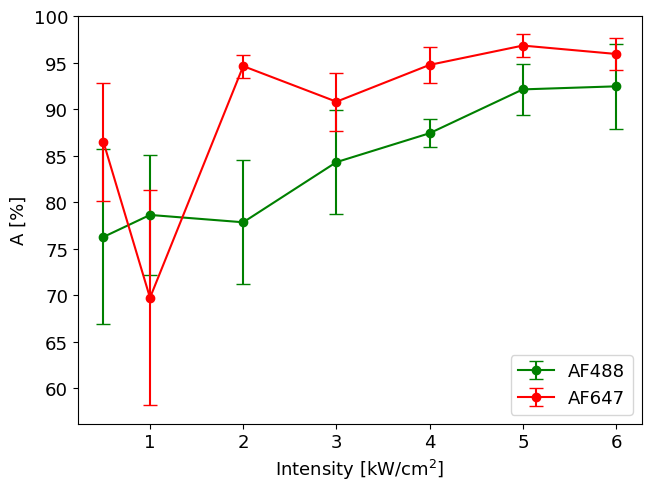

In [11]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], 100*np.array(all_A[0:7]), yerr=100*np.array(all_A_error[0:7]), marker='o', c='g', capsize=5, label='AF488')
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], 100*np.array(all_A[7:14]), yerr=100*np.array(all_A_error[7:14]), marker='o', c='r', capsize=5, label='AF647')
ax.set_xlabel('Intensity [kW/cm$^2$]')
ax.set_ylabel('A [%]')
ax.legend()
fig.savefig(data_path + '/A_fraction.svg', dpi=150)
plt.rcParams.update({'font.size': 10})

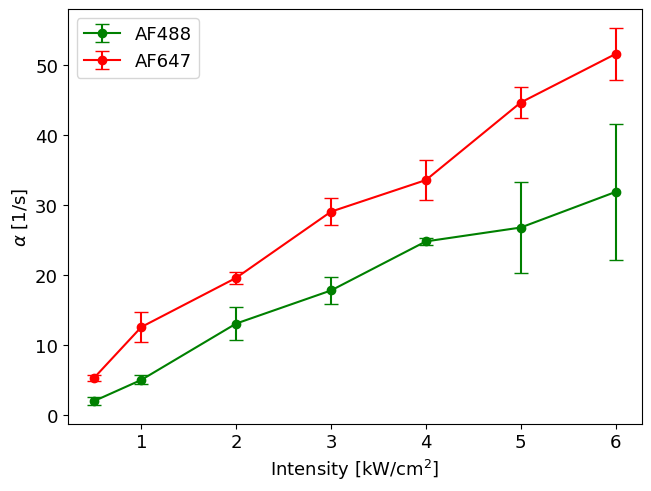

In [12]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], np.array(all_alpha[0:7]), yerr=np.array(all_alpha_error[0:7]), marker='o', c='g', capsize=5, label='AF488')
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], np.array(all_alpha[7:14]), yerr=np.array(all_alpha_error[7:14]), marker='o', c='r', capsize=5, label='AF647')
ax.set_xlabel('Intensity [kW/cm$^2$]')
ax.set_ylabel('$\\alpha$ [1/s]')
ax.legend()
fig.savefig(data_path + '/alpha.svg', dpi=150)
plt.rcParams.update({'font.size': 10})

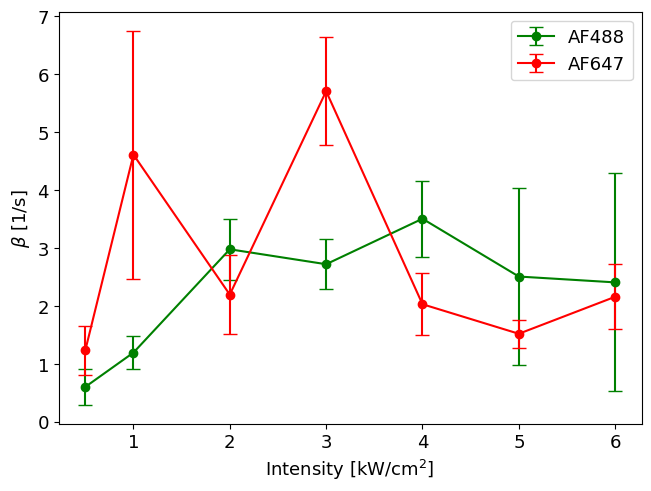

In [13]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], np.array(all_beta[0:7]), yerr=np.array(all_beta_error[0:7]), marker='o', c='g', capsize=5, label='AF488')
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], np.array(all_beta[7:14]), yerr=np.array(all_beta_error[7:14]), marker='o', c='r', capsize=5, label='AF647')
ax.set_xlabel('Intensity [kW/cm$^2$]')
ax.set_ylabel('$\\beta$ [1/s]')
ax.legend()
fig.savefig(data_path + '/beta.svg', dpi=150)
plt.rcParams.update({'font.size': 10})

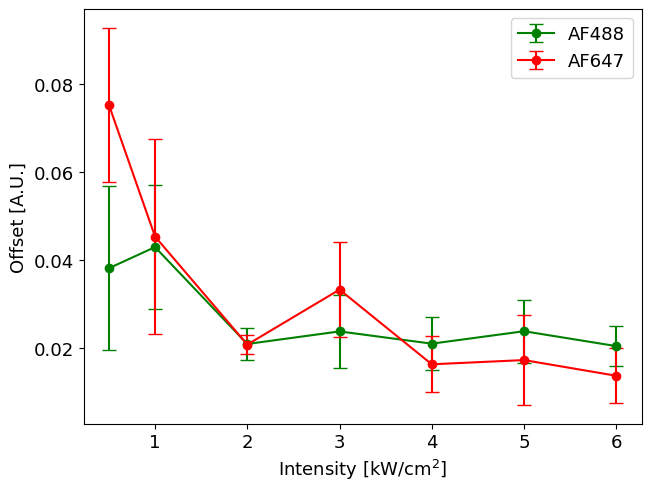

In [14]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], np.array(all_offset[0:7]), yerr=np.array(all_offset_error[0:7]), marker='o', c='g', capsize=5, label='AF488')
ax.errorbar([0.5, 1, 2, 3, 4, 5, 6], np.array(all_offset[7:14]), yerr=np.array(all_offset_error[7:14]), marker='o', c='r', capsize=5, label='AF647')
ax.set_xlabel('Intensity [kW/cm$^2$]')
ax.set_ylabel('Offset [A.U.]')
ax.legend()
fig.savefig(data_path + '/offset.svg', dpi=150)
plt.rcParams.update({'font.size': 10})

In [52]:
# Set index to plot fit
# See which indexes belong to which measurements where the groups are defined
index = 85
# Set name with which the fit shall be saved
savename = 'fit.svg'

print('Fluorophore '+all_files[index][79:84])
print('Intensity '+all_files[index][98:103])

Fluorophore AF647
Intensity 6000W


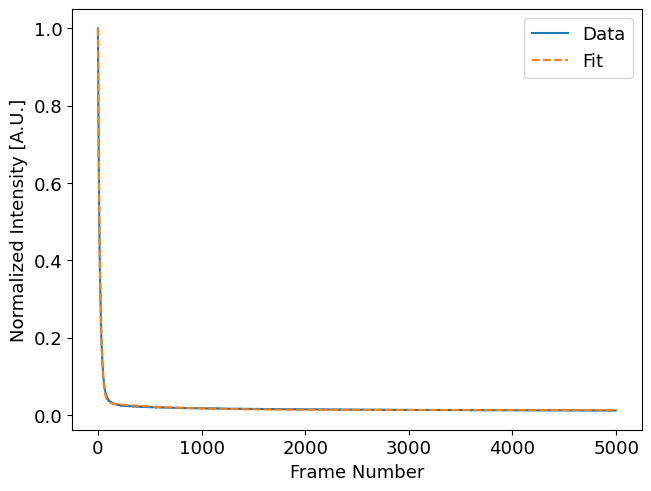

In [53]:
f = all_files[index]

with pims.open(f) as seq:
    temp = []
    for img in seq[2:]:
        temp.append(np.sum(img))
        
result_array = np.array(temp)
result_array = result_array/result_array[0]
popt, pcov = curve_fit(fit_func, np.arange(len(result_array)), result_array, p0=(0.6, 0.01, 0.001, 0), bounds=([0.5, 0.0, 0.0, 0], [1.0, np.inf, np.inf, np.inf]))
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(np.arange(len(result_array)), result_array, label='Data')
ax.plot(np.arange(len(result_array)), fit_func(np.arange(len(result_array)), *popt), '--', label='Fit')
ax.set_xlabel('Frame Number')
ax.set_ylabel('Normalized Intensity [A.U.]')
ax.legend()
fig.savefig(data_path + f'/{savename}.svg', dpi=150)
plt.rcParams.update({'font.size': 10})

In [54]:
# Set indexes to plot fit
# See which indexes belong to which measurements where the groups are defined
indexes = [80, 81, 82, 83, 84, 85]
# Set name with which the fit shall be saved
savename = 'fit_all.svg'

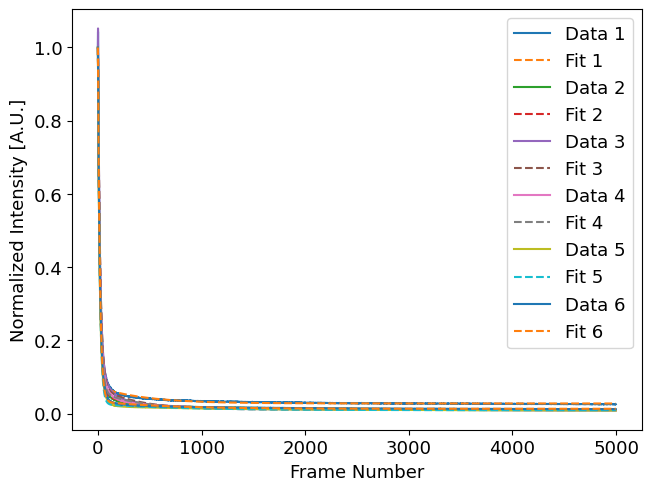

In [55]:
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(constrained_layout=True)
i = 0
for index in indexes:
    i += 1
    f = all_files[index]
    
    with pims.open(f) as seq:
        temp = []
        for img in seq[2:]:
            temp.append(np.sum(img))
            
    result_array = np.array(temp)
    result_array = result_array/result_array[0]
    popt, pcov = curve_fit(fit_func, np.arange(len(result_array)), result_array, p0=(0.6, 0.01, 0.001, 0), bounds=([0.5, 0.0, 0.0, 0], [1.0, np.inf, np.inf, np.inf]))
    
    ax.plot(np.arange(len(result_array)), result_array, label=f'Data {i}')
    ax.plot(np.arange(len(result_array)), fit_func(np.arange(len(result_array)), *popt), '--', label=f'Fit {i}')
ax.set_xlabel('Frame Number')
ax.set_ylabel('Normalized Intensity [A.U.]')
ax.legend()
fig.savefig(data_path + f'/{savename}.svg', dpi=150)
plt.rcParams.update({'font.size': 10})